# Fine-tune model for **NUF** clustering

In [21]:
import pandas as pd
import numpy as np

import json
from itertools import combinations

from sentence_transformers import SentenceTransformer, InputExample, losses
# from sentence_transformers.evaluation import LabelAccuracyEvaluator

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# from transformers import MarianMTModel, MarianTokenizer

import torch
from torch.utils.data import DataLoader

In [4]:
# Load model
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

In [8]:
# Load df from data
df = pd.read_csv('./data/NUF_data.csv')
df.head()

,NC,Bezeichnung,NUF,bezeichnung_no_special_ch,concat_text
0,111,wohnräume,NUF_1,wohnraume,wohnräume | wohnraume
1,11111,wohnraum/ schlafraum,NUF_1,wohnraum/ schlafraum,wohnraum/ schlafraum | wohnraum/ schlafraum
2,11112,wohnraum/ schlafraum mit rlt 1,NUF_1,wohnraum/ schlafraum mit rlt 1,wohnraum/ schlafraum mit rlt 1 | wohnraum/ sch...
3,11121,küche in wohnung,NUF_1,kuche in wohnung,küche in wohnung | kuche in wohnung
4,11122,küche in wohnung mit rlt 1,NUF_1,kuche in wohnung mit rlt 1,küche in wohnung mit rlt 1 | kuche in wohnung ...


In [9]:
# Create a dataset that contains unique pairs for 'concat_text' input and applies the
# indicator class that teaches model if two classes within the pair should be similar to each other.

# Make only unique pairs (or random as an option)
examples = []
for i, j in combinations(range(len(df)), 2):  # Unique pairs
    row, row2 = df.iloc[i], df.iloc[j]
    label = 1 if row['NUF'] == row2['NUF'] else 0
    examples.append(InputExample(
        texts=[row['concat_text'], row2['concat_text']],
        label=label
    ))

In [11]:
# Display the first 5 pairs of sentences with their labels
for example in examples[:5]:
    print(f"Sentence 1: {example.texts[0]}")
    print(f"Sentence 2: {example.texts[1]}")
    print(f"Label: {example.label}")
    print("-" * 50)

Sentence 1: wohnräume | wohnraume
Sentence 2: wohnraum/ schlafraum | wohnraum/ schlafraum
Label: 1
--------------------------------------------------
Sentence 1: wohnräume | wohnraume
Sentence 2: wohnraum/ schlafraum mit rlt 1 | wohnraum/ schlafraum mit rlt 1
Label: 1
--------------------------------------------------
Sentence 1: wohnräume | wohnraume
Sentence 2: küche in wohnung | kuche in wohnung
Label: 1
--------------------------------------------------
Sentence 1: wohnräume | wohnraume
Sentence 2: küche in wohnung mit rlt 1 | kuche in wohnung mit rlt 1
Label: 1
--------------------------------------------------
Sentence 1: wohnräume | wohnraume
Sentence 2: diele | diele
Label: 1
--------------------------------------------------


In [12]:
len(examples)

528906

## GPU availability

In [ ]:
# use GPU for model tuning
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Number of GPUs available

```
True

1
```

In [ ]:
model.to('cuda')

```
SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: XLMRobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

```

## Model training

In [ ]:
train_loss = losses.CosineSimilarityLoss(model=model)
train_dataloader = DataLoader(examples, shuffle=True, batch_size=64)

warmup_steps = int(0.005 * len(train_dataloader))

In [ ]:
# The model has been run on Google Colab. To replicate this, please follow the link and create an account at https://wandb.me/wandb-core. 
# Once registered, you will receive a key to run the model.

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=1,
    warmup_steps=warmup_steps,
    optimizer_params={'lr': 3e-5},
    show_progress_bar=True
)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.

wandb: Currently logged in as: <your-account-name>. Use `wandb login --relogin` to force relogin

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.

Tracking run with wandb version 0.19.2

Run data is saved locally in /content/wandb/run-20250122_120243-ggedoah4

Syncing run checkpoints/model_1 to Weights & Biases (docs)

View project at https://wandb.ai/<your-account-name>/sentence-transformers

View run at https://wandb.ai/<your-account-name>/sentence-transformers/runs/ggedoah4

In [ ]:
# Save the fine-tuned model
model.save('./fine_tuned_model_for_NUF_clustering_v5')

## Check the fine-tuned model

In [14]:
model = SentenceTransformer('./fine_tuned_model_for_NUF_clustering_v5')

print(model)

You try to use a model that was created with version 3.3.1, however, your version is 3.2.1. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: XLMRobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)


In [15]:
df['embeddings_pmmb_ft'] = model.encode(df['Bezeichnung'].tolist(), normalize_embeddings=True, convert_to_numpy=True).tolist()
df.head()

,NC,Bezeichnung,NUF,bezeichnung_no_special_ch,concat_text,embeddings_pmmb_ft
0,111,wohnräume,NUF_1,wohnraume,wohnräume | wohnraume,"[-0.04383322596549988, -0.0013424523640424013,..."
1,11111,wohnraum/ schlafraum,NUF_1,wohnraum/ schlafraum,wohnraum/ schlafraum | wohnraum/ schlafraum,"[-0.04055038467049599, -0.008995863609015942, ..."
2,11112,wohnraum/ schlafraum mit rlt 1,NUF_1,wohnraum/ schlafraum mit rlt 1,wohnraum/ schlafraum mit rlt 1 | wohnraum/ sch...,"[-0.03953994810581207, -0.011370697058737278, ..."
3,11121,küche in wohnung,NUF_1,kuche in wohnung,küche in wohnung | kuche in wohnung,"[-0.04679613560438156, 0.001380869303829968, -..."
4,11122,küche in wohnung mit rlt 1,NUF_1,kuche in wohnung mit rlt 1,küche in wohnung mit rlt 1 | kuche in wohnung ...,"[-0.043233390897512436, -0.0025524101220071316..."


In [16]:
embeddings_array = np.array(df['embeddings_pmmb_ft'].tolist())

In [17]:
# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
reduced_embeddings = tsne.fit_transform(embeddings_array)
df['TSNE_1_ft'] = reduced_embeddings[:, 0]
df['TSNE_2_ft'] = reduced_embeddings[:, 1]

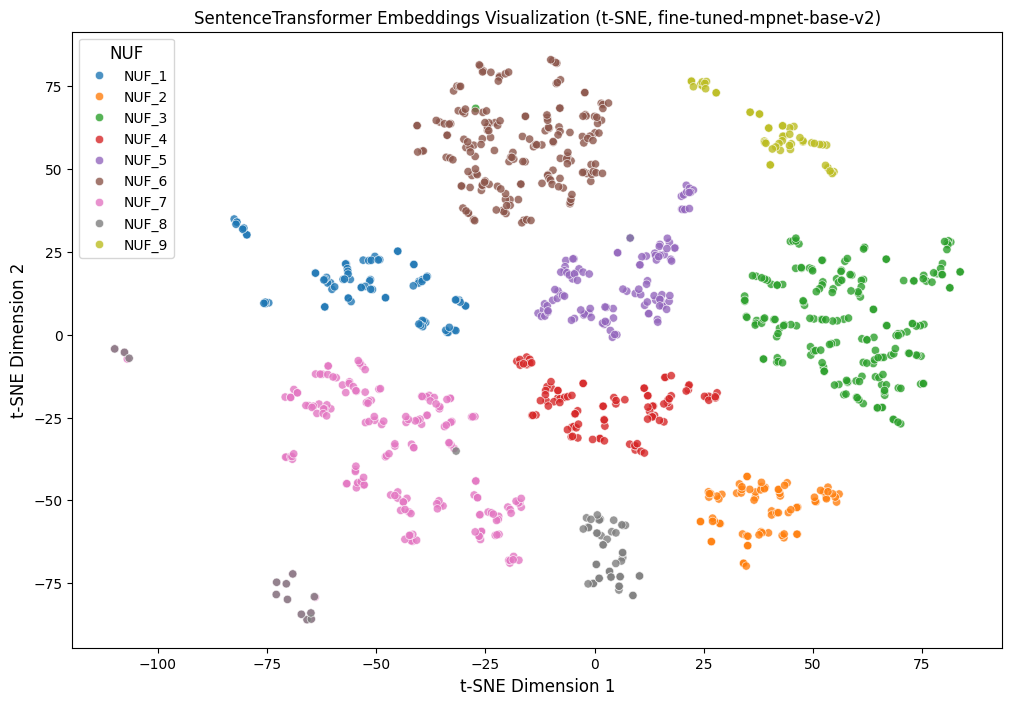

In [ ]:
# Plot the data with reduced dimentionality
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=df,
    x='TSNE_1_ft',
    y='TSNE_2_ft',
    hue='NUF',
    palette='tab10', 
    alpha=0.8 
)

plt.title("SentenceTransformer Embeddings Visualization (t-SNE, fine-tuned-mpnet-base-v2)", fontsize=12)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend(title='NUF', title_fontsize=12, fontsize=10) 

plt.show()

## Test the fine-tuned model

In [20]:
# Create mean embedding for each class
class_embeddings = {}
for label in df['NUF'].unique():
    class_rows = df[df['NUF'] == label]
    embeddings = np.vstack(class_rows['embeddings_pmmb_ft'].tolist())
    mean_embedding = np.mean(embeddings, axis=0)
    class_embeddings[label] = mean_embedding

In [ ]:
# Convert numpy arrays to lists for JSON serialization
class_embeddings_serializable = {label: embedding.tolist() for label, embedding in class_embeddings.items()}

# Save to a JSON file
with open('./class_embeddings.json', 'w') as f:
    json.dump(class_embeddings_serializable, f)

In [ ]:
def assign_top_k_classes(new_text, model, class_embeddings, k=2):
    """
    Returns the top k class predictions for the given text, along with their
    relative confidence scores (based on cosine similarity).
    """
    # Compute embedding for the new text
    new_embedding = model.encode(new_text, normalize_embeddings=True, convert_to_numpy=True)

    # Compute similarity of new_embedding with each class prototype
    class_scores = {}
    for class_label, prototype in class_embeddings.items():
        similarity = cosine_similarity(
            new_embedding.reshape(1, -1),
            prototype.reshape(1, -1)
        )[0][0]
        class_scores[class_label] = similarity

    # Sort classes by descending similarity
    sorted_scores = sorted(class_scores.items(), key=lambda x: x[1], reverse=True)

    # Compute confidence as (similarity / sum_of_all_similarities) * 100
    sum_of_scores = sum(class_scores.values())
    top_k_classes = []
    for class_label, sim in sorted_scores[:k]:
        if sum_of_scores != 0:
            confidence = (sim / sum_of_scores) * 100
        else:
            confidence = 0.0
        top_k_classes.append((class_label, confidence))

    return top_k_classes

In [24]:
new_room = "Wohnung"

top_2_results = assign_top_k_classes(new_room.lower(), model, class_embeddings, k=2)

print(f"Top 2 predictions for '{new_room}':")
for rank, (cls, conf) in enumerate(top_2_results, start=1):
    print(f"  {rank}. {cls} ({conf:.2f}% confidence)")

Top 2 predictions for 'Wohnung':
  1. NUF_1 (86.55% confidence)
  2. NUF_7 (6.70% confidence)
